In [11]:
!pip install pandas numpy matplotlib seaborn scikit-learn tqdm
import json
import pandas as pd

with open('user-wallet-transactions.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


Defaulting to user installation because normal site-packages is not writeable


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [15]:
df.info()
df['action'].value_counts()
df['userWallet'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   _id          100000 non-null  object
 1   userWallet   100000 non-null  object
 2   network      100000 non-null  object
 3   protocol     100000 non-null  object
 4   txHash       100000 non-null  object
 5   logId        100000 non-null  object
 6   timestamp    100000 non-null  int64 
 7   blockNumber  100000 non-null  int64 
 8   action       100000 non-null  object
 9   actionData   100000 non-null  object
 10  __v          100000 non-null  int64 
 11  createdAt    100000 non-null  object
 12  updatedAt    100000 non-null  object
dtypes: int64(3), object(10)
memory usage: 9.9+ MB


3497

In [13]:
print(df.columns.tolist())


['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt', 'updatedAt']


In [14]:
df['userWallet'].nunique()

3497

In [20]:
import numpy as np
import pandas as pd
df['timestamp'] = pd.to_datetime(df['timestamp'])

def extract_amount(row):
    try:
        amt = row['actionData'].get('amount', 0)
        return int(amt) / 1e18
    except:
        return 0

df['amount'] = df.apply(extract_amount, axis=1)


wallet_groups = df.groupby('userWallet')

features = []

for user, group in wallet_groups:
    actions = group['action'].value_counts().to_dict()
    
    total_deposit = group[group['action'] == 'deposit']['amount'].sum()
    total_borrow = group[group['action'] == 'borrow']['amount'].sum()
    total_repay = group[group['action'] == 'repay']['amount'].sum()
    total_redeem = group[group['action'] == 'redeemunderlying']['amount'].sum()
    
    liquidation_count = actions.get('liquidationcall', 0)
    repay_to_borrow = total_repay / total_borrow if total_borrow > 0 else 0
    borrow_to_deposit = total_borrow / total_deposit if total_deposit > 0 else 0
    
    tx_count = len(group)
    days_active = (group['timestamp'].max() - group['timestamp'].min()).days + 1
    tx_per_day = tx_count / days_active if days_active > 0 else tx_count
    
    features.append({
        'user': user,
        'total_deposit': total_deposit,
        'total_borrow': total_borrow,
        'total_repay': total_repay,
        'total_redeem': total_redeem,
        'repay_to_borrow': repay_to_borrow,
        'borrow_to_deposit': borrow_to_deposit,
        'liquidation_count': liquidation_count,
        'tx_per_day': tx_per_day,
        'action_diversity': len(group['action'].unique()),
    })

feature_df = pd.DataFrame(features)
feature_df.head()


,user,total_deposit,total_borrow,total_repay,total_redeem,repay_to_borrow,borrow_to_deposit,liquidation_count,tx_per_day,action_diversity
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2.000000e-09,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0,1.0,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,1.450000e+02,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0,1.0,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.000000e-03,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0,2.0,1
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000e+00,0.0,0.000000e+00,4.835297,0.000000e+00,0.000000,0,17.0,1
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,9.459366e+04,39460.0,7.002457e-08,39465.558797,1.774571e-12,0.417153,0,399.0,4


In [18]:
print(df['actionData'].head(5))


0    {'type': 'Deposit', 'amount': '2000000000', 'a...
1    {'type': 'Deposit', 'amount': '145000000000000...
2    {'type': 'Deposit', 'amount': '100000000000000...
3    {'type': 'Deposit', 'amount': '400000000000000...
4    {'type': 'RedeemUnderlying', 'amount': '501548...
Name: actionData, dtype: object


In [21]:
from sklearn.preprocessing import MinMaxScaler
X = feature_df.drop(columns=['user'])
X = X.fillna(0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Example weights 
weights = np.array([1, 1, 2, 1, 3, -2, -3, 1, 2])  

raw_scores = X_scaled @ weights
min_score, max_score = raw_scores.min(), raw_scores.max()
credit_scores = 1000 * (raw_scores - min_score) / (max_score - min_score)

feature_df['credit_score'] = credit_scores.round().astype(int)
feature_df[['user', 'credit_score']].head()


,user,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,158
1,0x000000000051d07a4fb3bd10121a343d85818da6,158
2,0x000000000096026fb41fc39f9875d164bd82e2dc,158
3,0x0000000000e189dd664b9ab08a33c4839953852c,158
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,319


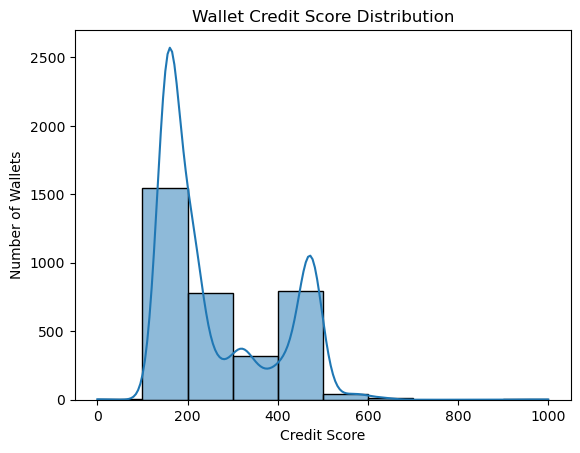

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(feature_df['credit_score'], bins=10, kde=True)
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.show()


In [23]:
feature_df['score_band'] = pd.cut(feature_df['credit_score'], bins=range(0, 1100, 100))

band_summary = feature_df.groupby('score_band').agg({
    'total_borrow': 'mean',
    'total_repay': 'mean',
    'liquidation_count': 'mean',
    'tx_per_day': 'mean'
}).round(2)

band_summary


C:\Users\DELL\AppData\Local\Temp\ipykernel_4484\968425521.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_summary = feature_df.groupby('score_band').agg({


,total_borrow,total_repay,liquidation_count,tx_per_day
score_band,,,,
"(0, 100]",300.67,0.00,0.00,3.00
"(100, 200]",8.07,1.12,0.04,3.76
"(200, 300]",8216.35,2.44,0.08,26.66
"(300, 400]",64084.55,7075.23,0.19,90.51
"(400, 500]",76215.61,26305.12,0.06,52.52
"(500, 600]",290240.81,281355.38,0.44,57.35
"(600, 700]",931.02,1865.95,0.00,15.78
"(700, 800]",NaN,NaN,NaN,NaN
"(800, 900]",NaN,NaN,NaN,NaN


In [25]:
feature_df[['user', 'credit_score']].to_csv("wallet_scores.csv", index=False)
